In [1]:
%pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [3]:
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.library import MCPhaseGate
import qiskit.quantum_info as qi
import numpy as np
import pandas
import matplotlib.pyplot as plt


from random import *
from math import *

sim = Aer.get_backend('aer_simulator')
sim.set_options(device = 'GPU')

Total Assembly Time - 0.13304 (ms)
Total Assembly Time - 0.21672 (ms)
Total Assembly Time - 0.15283 (ms)
Total Assembly Time - 0.11969 (ms)
Total Assembly Time - 0.08011 (ms)
Total Assembly Time - 0.06437 (ms)
Total Assembly Time - 0.06938 (ms)
Total Assembly Time - 0.07081 (ms)
Total Assembly Time - 0.06986 (ms)
Total Assembly Time - 0.78988 (ms)
Total Assembly Time - 0.14758 (ms)


In [4]:

def phase_normalize(alfa,a):
  return (alfa / a)  * (pi/2)

def phase_denormalize(norm,a):
  return ((norm * a) / (pi/2))

def Uw_phi(basis,phi,n):
  reg_q = QuantumRegister(n,"qr")
  circ_Uwp = QuantumCircuit(reg_q)
  neg = []
  for i,bit in enumerate(basis):
    if bit == "0":
      neg.append(i)
      circ_Uwp.x(i)
  circ_Uwp.append(MCPhaseGate(-phi,n-1),reg_q)
  for i in neg:
    circ_Uwp.x(i)
  circ_Uwp.barrier()
  return circ_Uwp

def Uw(W_phi, n):
  reg_q = QuantumRegister(n,"qr")
  circ_Uw = QuantumCircuit(reg_q)

  for i in range(1,len(W_phi)):
    basis = bin(i)[2:]
    while(len(basis) < n):
      basis = '0' + basis
    circ_Uw.compose(Uw_phi(basis,W_phi[i] - W_phi[0],n),reg_q,inplace = True)

  circ_Uw.h(reg_q)
  return circ_Uw

def Ui_theta(basis,theta,n):
  reg_q = QuantumRegister(n,"qr")
  circ_Uit = QuantumCircuit(reg_q)
  neg = []
  for i,bit in enumerate(basis):
    if bit == "0":
      neg.append(i)
      circ_Uit.x(i)
  circ_Uit.append(MCPhaseGate(theta,n-1),reg_q)
  for i in neg:
    circ_Uit.x(i)
  circ_Uit.barrier()
  return circ_Uit

def Ui(train_set_x, n):
  reg_q = QuantumRegister(n,"qr")
  circ_Ui = QuantumCircuit(reg_q)
  circ_Ui.h(reg_q)
  for i in range(1,len(train_set_x)):
    basis = bin(i)[2:]
    while(len(basis) < n):
      basis = '0' + basis
    circ_Ui.compose(Ui_theta(basis,train_set_x[i] - train_set_x[0],n),reg_q,inplace = True)
  return circ_Ui


def PerceptronCircuit(train_set_x, w_set, n):
    reg_q = QuantumRegister(n,"qr")
    reg_aux = QuantumRegister(1, "aux")
    cla_aux = ClassicalRegister(1)
    total = n + 1
    circ_perc = QuantumCircuit(reg_q,reg_aux,cla_aux)

    circ_perc.barrier()
    circ_perc.compose(Ui(train_set_x,n),range(n), inplace = True)
    circ_perc.compose(Uw(w_set,n),range(n), inplace = True)
    circ_perc.x(reg_q)
    circ_perc.mcx(reg_q,reg_aux)
    circ_perc.measure(reg_aux,cla_aux)
    return circ_perc




In [33]:

def initialize(train_set_x,sz):
    w = np.array([uniform(0,pi/2) for i in range(sz)])
    train_set_x = phase_normalize(train_set_x,255)
    return w, train_set_x

# tem que estar normalizado
def get_activation(w,train_set_x,num_shots = 8192):
    m = len(train_set_x[0])
    n = ceil(log2(m))
    set_size = len(train_set_x)
    A = np.array([])
    for pos,train_input in enumerate(train_set_x):
        model = PerceptronCircuit(train_input, w, n)
        qobj = assemble(model)   
        counts = sim.run(qobj,shots = num_shots).result().get_counts()
        if "1" in counts:
            A = np.append(A,counts["1"]/ num_shots)
        else:
            A = np.append(A,0.)
    A = A.reshape(set_size,1)
    return A

def get_dJ(w):
    u = train_set_x - w     # theta - phi
    c = np.cos(u)           # cos(theta - phi)
    C = c.sum(axis = 1).reshape(1,set_size).T
    s = np.sin(u)
    S = s.sum(axis = 1).reshape(1,set_size).T
    A = (C * C + S * S) / 2**(2 * n)
    return (2 * (s*C - c*S) / 2**(2 * n)) * A/set_size

def get_A(w,train_set_x,n):## Função exata de A
    set_size = len(train_set_x)
    u = train_set_x - w     # theta - phi
    c = np.cos(u)           # cos(theta - phi)
    C = c.sum(axis = 1).reshape(1,set_size).T
    s = np.sin(u)
    S = s.sum(axis = 1).reshape(1,set_size).T
    return (C * C + S * S)/2**(2*n)

def propagate(w,train_set_x,train_set_y):
    A = get_activation(w,train_set_x)
    diff = A - train_set_y
    cost = np.sum(diff ** 2)
    dA = get_dA(w,train_set_x,n)
    dw = 2 * dA * (diff)
    return dw, cost

def optimize(w,train_set_x,train_set_y, Hyperparameters):
    for i in range(Hyperparameters["iterations"]):
       dw, cost = propagate(w,train_set_x,train_set_y, Hyperparameters["num_shots"])
       w = w - (Hyperparameters["learning_rate"] * dw)
            
    return w

In [25]:
import fiftyone as fo
import fiftyone.zoo as foz


dataset_train = foz.load_zoo_dataset(
    "open-images-v6",
    split = "train",
    label_types = ["classifications"],
    classes = ["Cat"],
    max_samples = 2000,

)
dataset_test = foz.load_zoo_dataset(
    "open-images-v6",
    split = "test",
    label_types = ["classifications"],
    classes = ["Cat"],
    max_samples = 2000,
)


Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v6-train-2000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Only found 1211 (<2000) samples matching your requirements
Necessary images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'open-images-v6-test-2000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [46]:

from PIL import Image,ImageOps

def load_params():
    w = np.load("./params/w.npy")
    Hyperparameters = np.load("./params/Hyperparameters.npy")
    return w, Hyperparameters
    

def load_images(path):
    images = np.array([])
    images = images.reshape(0,64 * 64)
    for filename in os.listdir(path):
        f = os.path.join(path, filename)
        if os.path.isfile(f):
            image_np = load_image(f)
            images = np.vstack((images,image_np[0]))
    return images

def load_image(f):
    image = ImageOps.grayscale(Image.open(f))
    image = image.resize((64,64))
    image_np = np.array(image)
    image_np = image_np.reshape(1,64 * 64)
    return image_np


def prepare_images_labels(dataset):
    set_y = np.zeros(len(dataset))
    set_x = np.array([])
    set_x = set_x.reshape(0,64 * 64)
    for pos,i in enumerate(dataset):
        image_np = load_image(i["filepath"])
        set_x = np.vstack((set_x,image_np[0]))
        for j in range(len(i.positive_labels.to_dict()["classifications"])):
            if i.positive_labels.to_dict()["classifications"][j]['label'] == "Cat":
                set_y[pos] = 1
                break
    return set_x, set_y

def load_data(dataset_train,dataset_test):
    train_set_x, train_set_y = prepare_images_labels(dataset_train)
    test_set_x, test_set_y = prepare_images_labels(dataset_test)
    save_data_ararys(train_set_x,train_set_y,test_set_x,test_set_y)
    return train_set_x, train_set_y, test_set_x, test_set_y
    
train_set_x, train_set_y, test_set_x, test_set_y = load_data(dataset_train,dataset_test)    

In [47]:
from qiskit.algorithms.optimizers import SPSA

m = len(train_set_x[0])
set_size = len(train_set_y)
n = ceil(log2(m))
w, train_set_x = initialize(train_set_x,m)
Hyperparameters = {
"iterations" : 1000,
"threshold" : 0.5,
}
def powerseries(eta=0.01, power=2, offset=0):
    k = 1
    while True:
        yield eta / ((n + offset) ** power)
        k += 1

def learning_rate():
    return powerseries(31.860244892404292, 0.602, 0)

def perturbation():
    return powerseries(0.2,  0.101)

spsa = SPSA(maxiter=Hyperparameters["iterations"],learning_rate=learning_rate,perturbation=perturbation)
costs = []

    
def loss_func(w):
    set_size = len(train_set_x)
    A = get_A(w,train_set_x,n)
    diff = A.reshape(set_size,1) - train_set_y.reshape(set_size,1)
    cost = np.sum(diff ** 2) / set_size
    print("Custo {}".format(cost))
    costs.append(cost)
    return cost

def predict(test_set_y, w, Hyperparameters):
   A = get_A(w,test_set_y,n)
   labels = np.array([1 if i > Hyperparameters["threshold"] else 0 for i in A])
   return labels

result = spsa.optimize(num_vars=1,objective_function=loss_func,gradient_function=get_dJ, initial_point = w)


SPSA: Starting optimization.
Custo 0.2548354085762488
Custo 0.2541721942609917
Iteration 1/1001 done in 0.6376807689666748.
Custo 0.25449776532282226
Custo 0.2543757847200401
Iteration 2/1001 done in 0.6239359378814697.
Custo 0.25455940061823723
Custo 0.25431018682612216
Iteration 3/1001 done in 0.60675048828125.
Custo 0.2546881698369208
Custo 0.25416666528225845
Iteration 4/1001 done in 0.5990490913391113.
Custo 0.254264771230901
Custo 0.2545091742602763
Iteration 5/1001 done in 0.6211104393005371.
Custo 0.2535780949015443
Custo 0.2552137968048568
Iteration 6/1001 done in 0.614152193069458.
Custo 0.2535839829896732
Custo 0.2544111336843162
Iteration 7/1001 done in 0.6653957366943359.
Custo 0.2542296592780962
Custo 0.2535611422831616
Iteration 8/1001 done in 0.6269111633300781.
Custo 0.2541323811171808
Custo 0.2535310953810411
Iteration 9/1001 done in 0.585350751876831.
Custo 0.25433603942451166
Custo 0.25324019551818594
Iteration 10/1001 done in 0.6095633506774902.
Custo 0.25329398129

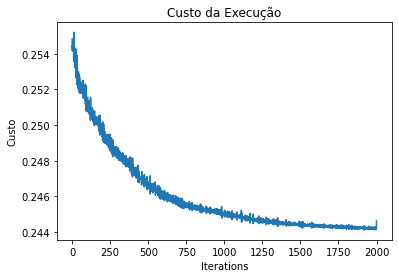

83.56729975227086


In [48]:
labels = predict(phase_normalize(test_set_x,255),w,Hyperparameters)
np.save("../src/params/w_num.npy",w)
acc = (100 - np.mean(np.abs(labels - test_set_y)) * 100)
plt.clf()
plt.plot(costs, label = "Custo da i-ésima execução.")
plt.xlabel("Iterations")
plt.ylabel("Custo")
plt.title("Custo da Execução")
plt.savefig("train_cost.jpg")
plt.show()
print(acc)

In [135]:

m = len(train_set_x[0])
set_size = len(train_set_y)
n = ceil(log2(m))
def compare(w,train_set_x,n):
    A1 = get_A(w,train_set_x,n)
    A2 = get_activation(w,train_set_x)
    return A1,A2
A1,A2 = compare(w,train_set_x,n)


Total Assembly Time - 0.11468 (ms)
Total Assembly Time - 0.11444 (ms)
Total Assembly Time - 0.07963 (ms)
Total Assembly Time - 0.09179 (ms)
Total Assembly Time - 0.08512 (ms)
Total Assembly Time - 0.11754 (ms)
Total Assembly Time - 0.07224 (ms)
Total Assembly Time - 0.07010 (ms)
Total Assembly Time - 0.10514 (ms)
Total Assembly Time - 0.08988 (ms)
Total Assembly Time - 0.19884 (ms)
Total Assembly Time - 0.18406 (ms)
Total Assembly Time - 0.11110 (ms)
Total Assembly Time - 0.13924 (ms)
Total Assembly Time - 0.12279 (ms)
Total Assembly Time - 0.07319 (ms)
Total Assembly Time - 0.07248 (ms)
Total Assembly Time - 0.07153 (ms)
Total Assembly Time - 0.07296 (ms)
Total Assembly Time - 0.12898 (ms)
Total Assembly Time - 0.09704 (ms)
Total Assembly Time - 0.08059 (ms)
Total Assembly Time - 0.06938 (ms)
Total Assembly Time - 0.10228 (ms)
Total Assembly Time - 0.08035 (ms)
Total Assembly Time - 0.14257 (ms)
Total Assembly Time - 0.07415 (ms)
Total Assembly Time - 0.11945 (ms)
Total Assembly Time 

0.014970006534984703 -0.014084975324135662


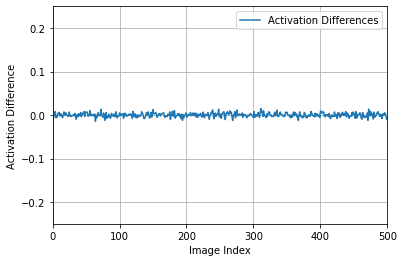

In [183]:
plt.clf()
A = A1 - A2.reshape(500,1)
plt.axis([0, 500, -0.25, 0.25])
plt.plot(A, label = "Activation Differences")
plt.xlabel("Image Index")
plt.ylabel("Activation Difference")
plt.legend()
mx_diff = np.max(A)
mn_diff = np.min(A)
print(mx_diff, mn_diff)
plt.legend()
plt.grid()
plt.savefig("Activation_Differences.jpg")
plt.show()

0.8356729975227085


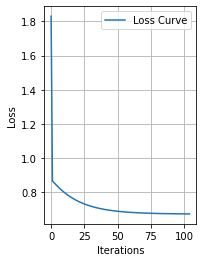

In [49]:
from sklearn.neural_network import MLPClassifier
plt.clf()
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(1, 1), random_state=1)
clf.fit(phase_denormalize(train_set_x,255), train_set_y)
print(clf.score(test_set_x, test_set_y))
plt.subplot(1, 2, 1)
plt.plot(clf.loss_curve_,label = "Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
#plt.savefig("loss_curve_perceptron.jpg")
plt.show()

0.8356729975227085


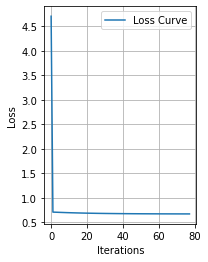

In [51]:
from sklearn.neural_network import MLPClassifier
plt.clf()
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(phase_denormalize(train_set_x,255), train_set_y)
print(clf.score(test_set_x, test_set_y))
plt.subplot(1, 2, 2)
plt.plot(clf.loss_curve_,label = "Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
#plt.savefig("loss_curve_sgd_52.jpg")
plt.show()


In [52]:
from sklearn.neural_network import MLPClassifier
plt.clf()
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(6, 5), random_state=1)
clf.fit(phase_denormalize(train_set_x,255), train_set_y)
print(clf.score(test_set_x, test_set_y))
plt.subplot(1, 2, 3)
plt.plot(clf.loss_curve_,label = "Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve_adam_65.jpg")
plt.show()

0.3740710156895128


ValueError: num must be 1 <= num <= 2, not 3

<Figure size 432x288 with 0 Axes>